In [1]:
import matplotlib.pylab as plt
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools

from dmba import load_data
from metrics import regression_summary

In [2]:
df = load_data("Amtrak.csv")
df["date"] = pd.to_datetime(df.month, format="%d/%m/%Y")
df.head()

,month,ridership,date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


In [3]:
# Convert dataframe column to series (name is used to label the data)
ridership_ts = pd.Series(df.ridership.values, index=df.date, name="Ridership")
ridership_ts.head()

date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Name: Ridership, dtype: float64

In [4]:
# Define the time series frequency.
ridership_ts.index = pd.DatetimeIndex(
    ridership_ts.index, freq=ridership_ts.index.inferred_freq
)
ridership_ts.head()

date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Freq: MS, Name: Ridership, dtype: float64

In [5]:
# Freq MS means Month-Start. For the list of aliases, see here
# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases

(1300.0, 2300.0)

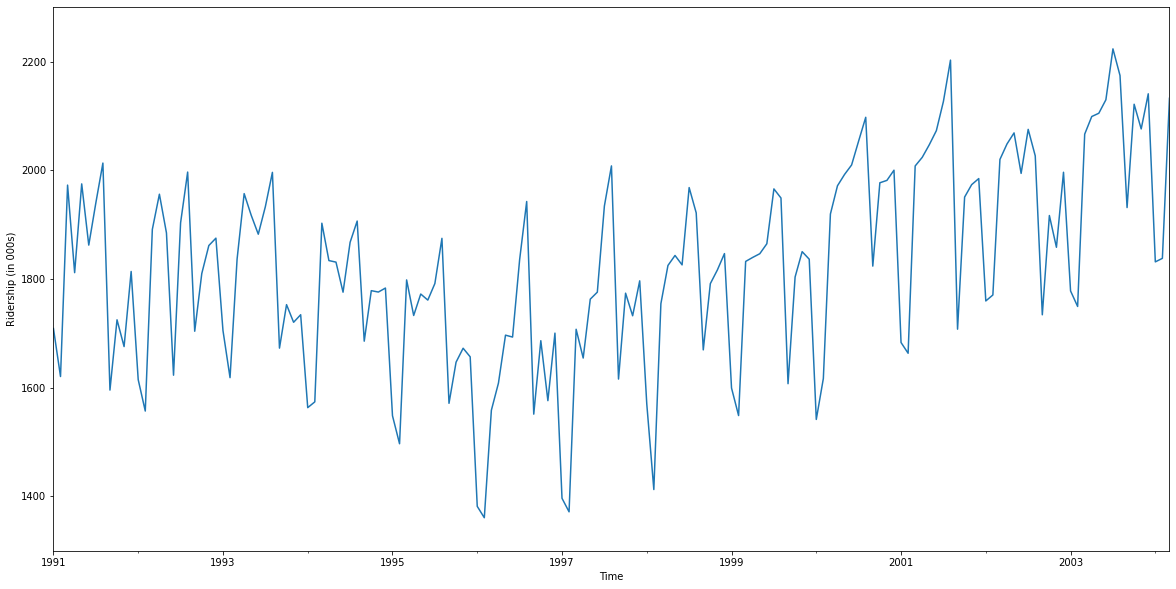

In [6]:
# Plot the series.
ax = ridership_ts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Ridership (in 000s)")
ax.set_ylim(1300, 2300)

In [7]:
# Create short time series from 1997 to 1999 using a slice.
ridership_ts_3yrs = ridership_ts["1997":"1999"]

# Create a data frame with additional predictors from time series
# The following command adds a constant term, a trend term and a quadratic trend term.
ridership_df = tsatools.add_trend(ridership_ts, trend="ctt")

<AxesSubplot:xlabel='date', ylabel='Ridership (in 000s)'>

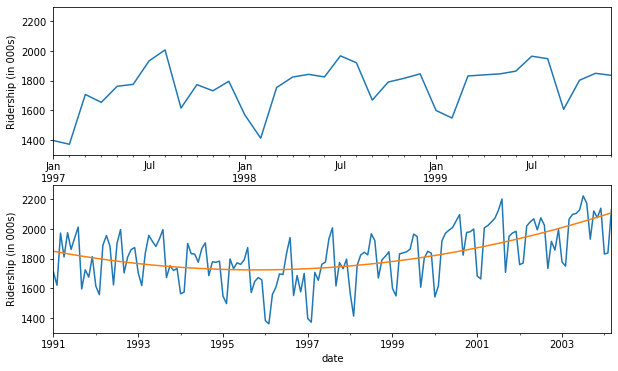

In [8]:
# Fit a linear regression model to the time series.
ridership_lm = sm.ols(
    formula="Ridership ~ trend + trend_squared", data=ridership_df
).fit()

# Shorter and longer time series
fix, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
ridership_ts_3yrs.plot(ax=axes[0])
ridership_ts.plot(ax=axes[1])

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylabel("Ridership (in 000s)")
    ax.set_ylim(1300, 2300)

ridership_lm.predict(ridership_df).plot(ax=axes[1])

## Benchmark performance: Naive Forecasts

In [9]:
n_valid = 36
n_train = len(ridership_ts) - n_valid

# Partition the data
train_ts = ridership_ts[:n_train]
valid_ts = ridership_ts[n_train:]

# Generate the naive and seasonal naive forecast.
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)

last_season = train_ts[12:]
seasonal_pred = pd.Series(
    pd.concat([last_season] * 5)[: len(valid_ts)].values, index=valid_ts.index
)

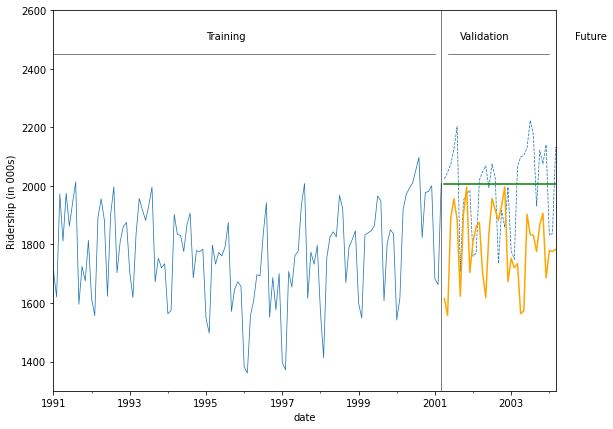

In [10]:
7  # Plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color="C0", linewidth=0.75, figsize=(9, 7))
valid_ts.plot(ax=ax, color="C0", linestyle="dashed", linewidth=0.75)
ax.set_xlim("1990", "2006-6")
ax.set_ylim(1300, 2600)
ax.set_xlabel("Time")
ax.set_ylabel("Ridership (in 000s)")


naive_pred.plot(ax=ax, color="green")
seasonal_pred.plot(ax=ax, color="orange")

# Determine coordinates for drawing the arrows and lines.
one_month = pd.Timedelta("31 days")
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, "2006")


xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])


ax.add_line(plt.Line2D(xtrain, (2450, 2450), color="black", linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color="black", linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450), color="black", linewidth=0.5))

ax.text("1995", 2500, "Training")
ax.text("2001-9", 2500, "Validation")
ax.text("2004-9", 2500, "Future")

ax.axvline(x=xtv, ymin=0, ymax=1, color="black", linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color="black", linewidth=0.5)

In [11]:
# Validation Set

regression_summary(valid_ts, naive_pred)

RMSE: 142.75509467791335
MAE: 115.92338888888887


In [12]:
regression_summary(valid_ts, seasonal_pred)

RMSE: 271.97065794646545
MAE: 222.40761111111112


In [13]:
# Training Set

regression_summary(train_ts[1:], train_ts[:-1])

RMSE: 168.14698957398878
MAE: 125.2975163934426


In [14]:
# Calculate seasonal naive metrics for training set (shifted by 12 months)
regression_summary(train_ts[12:], train_ts[:-12])

RMSE: 99.26556718798896
MAE: 82.49196396396397
